# Lab 3: Generating Data

Based on assignments by Lisa Zhang and Jimmy Ba.

In this lab, I will build models to perform image colourization. That is, given a greyscale image, we wish to predict the colour at each pixel. Image colourization is a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple, equally valid colourings.

To keep the training time manageable we will use the CIFAR-10 data set, which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. The data loading script is included with the notebooks, and should download automatically the first time it is loaded. 

We will be starting with a convolutional autoencoder and tweaking it along the way to improve our perforamnce. Then as a second part of the assignment we will compare the autoencoder approach to conditional generative adversarial networks (cGANs).

Process of this notebook:

1. Clean and process the dataset and create greyscale images.
2. Implement and modify an autoencoder architecture.
3. Tune the hyperparameters of an autoencoder.
4. Implement skip connections and other techniques to improve performance.
5. Implement a cGAN and compare with an autoencoder.
6. Improve on the cGAN by trying one of several techniques to enhance training.

## Colab Link

Colab Link: https://colab.research.google.com/drive/1aoqR_HJJGVugWP3iBnvTc4PQ78ZM8Ll8?usp=sharing

# PART A - Autoencoder

In this part we will construct and compare different autoencoder models for the image colourization task.

#### Helper code

Provided are some helper functions for loading and preparing the data. Need to use the Colab GPU for this notebook.

In [ ]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/a3/
%cd /content/a3

/content/a3


In [ ]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Download CIFAR dataset
m = load_cifar10()

File path: data/cifar-10-batches-py.tar.gz
Extracting file.


## Part 1. Data Preparation

To start off run the above code to load the CIFAR dataset and then work through the following questions/tasks. 

### Part (a)

Have verify that the dataset has loaded correctly. We have 50000 samples in the training set, 10000 samples in the test set. The data is organized in 'NCHW'.

In [ ]:
# code to examine the dataset
print("X_train shape: {}".format(m[0][0].shape))
print("y_train shape: {}".format(m[0][1].shape))
print("X_test  shape: {}".format(m[1][0].shape))
print("y_test  shape: {}".format(m[1][1].shape))

X_train shape: (50000, 3, 32, 32)
y_train shape: (50000, 1)
X_test  shape: (10000, 3, 32, 32)
y_test  shape: (10000, 1)


### Part (b)
Preprocess the data to select only images of horses. Learning to generate only hourse images will make our task easier.

In [ ]:
# select a single category.
HORSE_CATEGORY = 7

# convert colour images into greyscale
def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


In [ ]:
# training set
X_train, X_train_grey = process(m[0][0],m[0][1])
# test set
X_test,  X_test_grey  = process(m[1][0],m[1][1])
print(X_train.shape)
print(X_train_grey.shape)

(5000, 3, 32, 32)
(5000, 1, 32, 32)


### Part (c)
Create a dataloader (or function) to batch the samples.

In [ ]:
# dataloader for batching samples

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)

### Part (e)
Verify and visualize that we are able to generate different batches of data.

In [ ]:
# code to load different batches of horse dataset

print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)

### I think it is necessary to split training set and validation set
### and the later questions also ask about this.
validation_rgb = train_rgb[4000:,:,:,:]
train_rgb      = train_rgb[:4000,:,:,:]

validation_grey = train_grey[4000:,:,:,:]
train_grey      = train_grey[:4000,:,:,:]

print(train_rgb.shape)
print(validation_rgb.shape)
print(train_grey.shape)
print(validation_grey.shape)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
(4000, 3, 32, 32)
(1000, 3, 32, 32)
(4000, 1, 32, 32)
(1000, 1, 32, 32)


In [ ]:
# shape of data and labels before selection
print(x_train.shape, y_train.shape)

(50000, 3, 32, 32) (50000, 1)


In [ ]:
# shape of training data
print('Training Data: ', train_rgb.shape, train_grey.shape)
# shape of testing data
print('Testing  Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (4000, 3, 32, 32) (4000, 1, 32, 32)
Testing  Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


Load Batches

In [ ]:
# obtain batches of images
xs, ys = next(iter(get_batch(train_grey, train_rgb, 10)))
print(xs.shape, ys.shape)

(10, 1, 32, 32) (10, 3, 32, 32)


Visualization

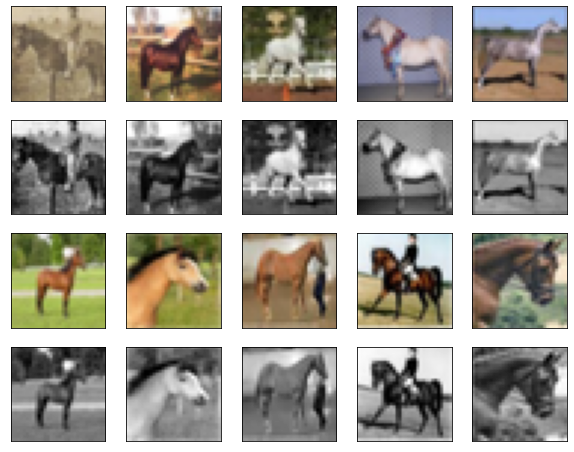

In [ ]:
# visualize 5 train/test images
fig = plt.figure(figsize = (10,8))
for i, img in enumerate(train_rgb[0:5,:,:,:]):
  plt.subplot(4, 5, i+1, xticks = [], yticks = [])
  plt.imshow(np.transpose(img,[1,2,0]))
for i, img in enumerate(train_grey[0:5,:,:,:]):
  plt.subplot(4, 5, i+6, xticks = [], yticks = [])
  plt.imshow(img[0], cmap = 'gray')
for i, img in enumerate(test_rgb[0:5,:,:,:]):
  plt.subplot(4, 5, i+11, xticks = [], yticks = [])
  plt.imshow(np.transpose(img,[1,2,0]))
for i, img in enumerate(test_grey[0:5,:,:,:]):
  plt.subplot(4, 5, i+16, xticks = [], yticks = [])
  plt.imshow(img[0], cmap = 'gray')

## Part 2. Colourization as Regression

There are many ways to frame the problem of image colourization as a machine learning problem. One naive approach is to frame it as a regression problem, where we build a model to predict the RGB intensities at each pixel given the greyscale input. In this case, the outputs are continuous, and so squared error can be used to train the model.

Regression Architecture

In [ ]:
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())
        
        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

Training code

In [ ]:
# define a loss calculator
def get_loss (model, xss, yss):
  """
  xs = train_grey_torch
  ys = train_rgb_torch
  """
  loss_list = []
  criterion = nn.MSELoss()
  for xs, ys in get_batch(xss, yss, args.batch_size):
    images, labels = get_torch_vars(xs, ys, args.gpu)
    outputs = model(images)
    loss = criterion(outputs, labels)
    # sum squared error for this batch
    loss_list.append(loss.cpu().detach()*args.batch_size)

  return np.sum(loss_list)/yss.shape[0]

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        torch.manual_seed(16)
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    
    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    print("Spliting data...")
    # split training set into train/validation set
    valid_rgb  = train_rgb[4000:,:,:,:]
    train_rgb  = train_rgb[:4000,:,:,:]
    valid_grey = train_grey[4000:,:,:,:]
    train_grey = train_grey[:4000,:,:,:]

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []

    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # record the performance at each epoch
        train_loss = get_loss(gen, train_grey, train_rgb)
        valid_loss = get_loss(gen, valid_grey, valid_rgb)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print('\r', "epoch %d, train loss: %.5f, validation loss: %.5f." %(epoch+1, train_loss, valid_loss), end='', flush = True)
    # visualize 5 imgs in itraining
    images, labels = get_torch_vars(train_grey[:5,:,:,:], train_rgb[:5,:,:,:], args.gpu)
    outputs = gen(images)
    visual(images, labels, outputs, args.gpu, 1)
    # visualize 5 imgs in testing
    images, labels = get_torch_vars(test_grey[-5:,:,:,:], test_rgb[-5:,:,:,:], args.gpu)
    outputs = gen(images)
    visual(images, labels, outputs, args.gpu, 1)
    # plotting
    plotting(train_losses, valid_losses)

    return gen, train_losses, valid_losses

Training visualization code

In [ ]:
# visualize training curve
def plotting(train_losses, valid_losses):
  n = len(train_losses)
  plt.title("Train and validation loss")
  plt.plot(range(1, n+1), train_losses, label = "train")
  plt.plot(range(1, n+1), valid_losses, label = "validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc = "best")
  plt.show()

In [ ]:
# visualize 5 train/test images
def visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  for i in range(5): # clip to [0,1]
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(np.clip(img_grey[i], 0, 1), cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(np.clip(img_real[i], 0, 1))
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(np.clip(img_fake[i], 0, 1))
      ax.axis("off")
  plt.show()

Main training loop for regression CNN

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Spliting data...
Beginning training ...
 epoch 25, train loss: 0.00944, validation loss: 0.00946.

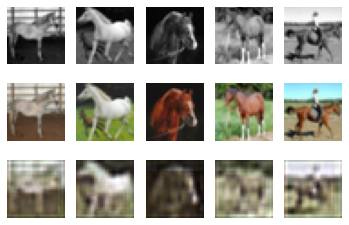

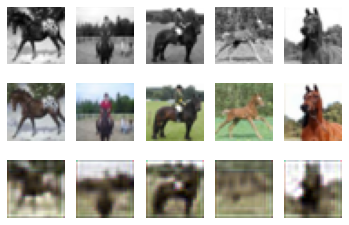

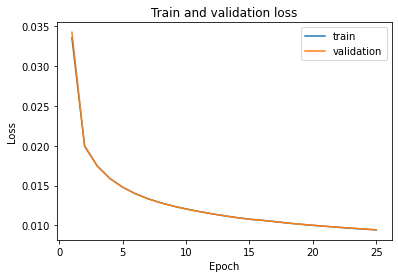

In [ ]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

### Part (a)
Description of the model RegressionCNN in a table.

Answer: There are 6 convolution layers in this model. The detailed information is as follows.
\begin{array}{l}
layer\ number & position\ of\ layer & in\ channel & number\ of\ filters\ (out\ channel) & filter\ size & \\
1 & downconv1 & 1 & num\_filters & kernel \\ 
2 & downconv2 & num\_filters &  num\_filters*2 & kernel \\ 
3 & rfconv & num\_filters*2 &  num\_filters*2 & kernel \\ 
4 & upconv1 & num\_filters*2 &  num\_filters & kernel \\ 
5 & upconv2 & num\_filters &  3 & kernel \\ 
6 & finalconv & 3 &  3 & kernel \\ 
\end{array}
The default setting: num_filters = 32, kernel = 3.

### Part (c)
Re-train a couple of new models using a different number of training epochs. As the number of epochs increases, (1) the output image is getting more and more clear from the initial blur; (2) the color of the output is approaching to the real RGB version of the imput; (3) the training loss decreases. Vice versa.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Spliting data...
Beginning training ...
 epoch 5, train loss: 0.01480, validation loss: 0.01481.

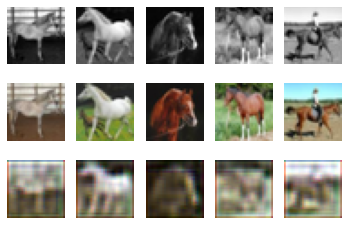

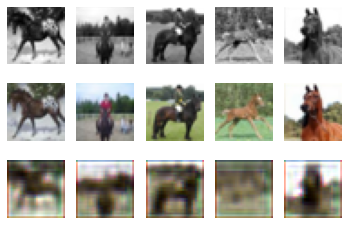

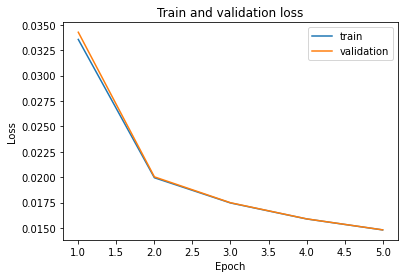

In [ ]:
# epochs = 5
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    ### changed below 
    "epochs": 5,
    ### changed above 
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Spliting data...
Beginning training ...
 epoch 200, train loss: 0.00514, validation loss: 0.00630.

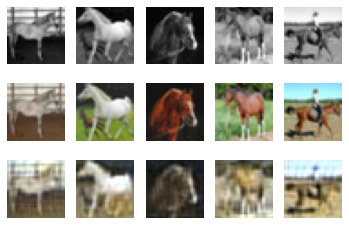

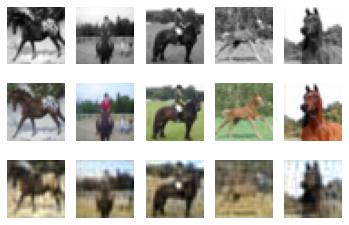

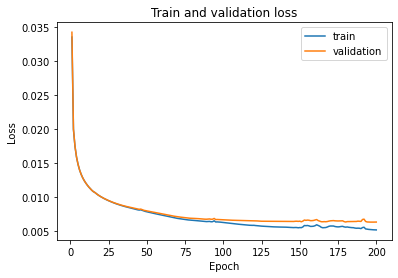

In [ ]:
# epochs = 200
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    ### changed below 
    "epochs": 200,
    ### changed above 
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

## Part 3. Skip Connections
A skip connection in a neural network is a connection which skips one or more layer and connects to a later layer. We will introduce skip connections.

### Part (a)
Add a skip connection from the first layer to the last, second layer to the second last, etc.
That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [3], and is called a "UNet". Following the CNN class that you have completed, complete the __init__ and forward methods of the UNet class.

In [ ]:
#complete the code

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1
        
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.finalconv = nn.Conv2d(num_filters+1, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        
                                          # input    # output
        out1 = self.downconv1(x)          # 1 ,32,32 # 32,16,16
        out2 = self.downconv2(out1)       # 32,16,16 # 64, 8, 8
        out3 = self.rfconv(out2)          # 64, 8, 8 # 64, 8, 8
        out4 = self.upconv1(out3)         # 64, 8, 8 # 32,16,16 
        out4 = torch.cat((out4, out1),1)  # skip connection # 32 + 32 = 64
        out5 = self.upconv2(out4)         # 32,16,16 # 1, 32,32 # 64 -> 32
        out5 = torch.cat((out5, x   ),1)  # skip connection # 32 + 1  = 33
        out6 = self.finalconv(out5)       # 1, 32,32 # 3, 32,32 # 33 -> 3
        return out6

        return out6

### Part (b)
Train the "UNet" model for the same amount of epochs as the previous CNN and plot the training curve using a batch size of 100. 

The result this time (UNet) is better than the previous in terms of loss and quality of the generated pictures.
<br> NO skip connection: train loss: 0.00944, validation loss: 0.00946.
<br> WITH skip connection: train loss: 0.00441, validation loss: 0.00437.
<br>The skip connections improve the training accuracy within 25 epochs, and improve the output qualitatively.

<br>Reasons of why skip connections improve the performance of CNN: <br>(1) the features extracted from the decoding process are directly depolyed (with the ones originally passed) in the encoding. Ie, the information is used for a second time. (2) the addtional term changes the gradients, which is helpful for optimizer to train the model quickly.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Spliting data...
Beginning training ...
 epoch 25, train loss: 0.00441, validation loss: 0.00437.

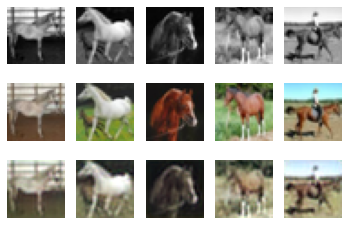

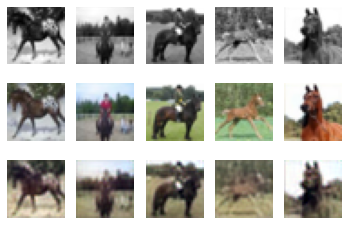

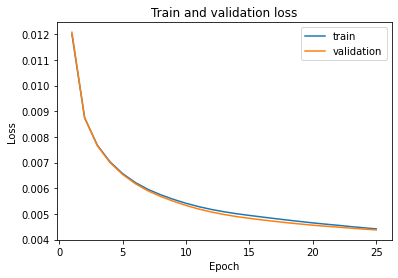

In [ ]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

### Part (c)
Re-train a few more "UNet" models using different mini batch sizes with a fixed number of epochs. 

I used (1)50 & (2)200 as batch sizes against the previous 100, with all epochs = 25.
<br>1. 50 batch size: train loss: 0.00362, validation loss: 0.00375.<br>2. 100 batch size: train loss: 0.00441, validation loss: 0.00437.
<br>3. 200 batch size: train loss: 0.00542, validation loss: 0.00551.
<br> Therefore, in the range of (50, 200), decreasing the batch size could help decrease the training/validation loss, as well as make the output image more clear and more similar to the original image in color.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Spliting data...
Beginning training ...
 epoch 25, train loss: 0.00363, validation loss: 0.00375.

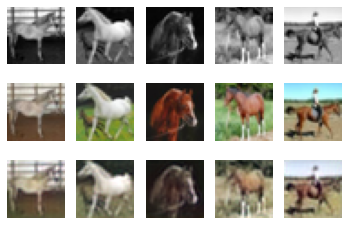

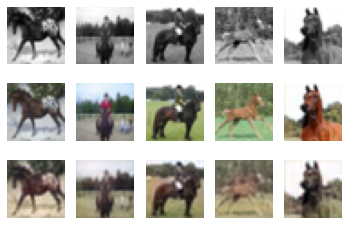

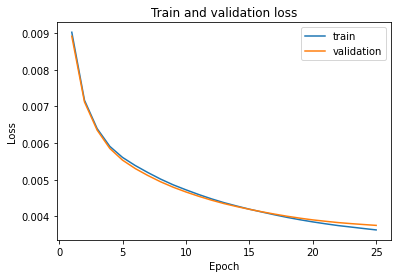

In [ ]:
# batch = 50
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    ### changed below
    "batch_size": 50,
    ### changed above
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Spliting data...
Beginning training ...
 epoch 25, train loss: 0.00542, validation loss: 0.00551.

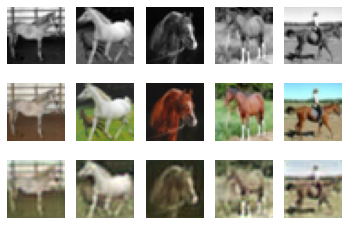

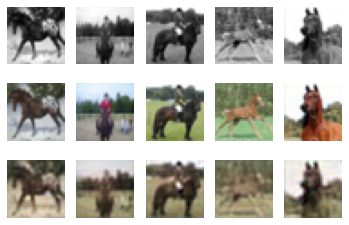

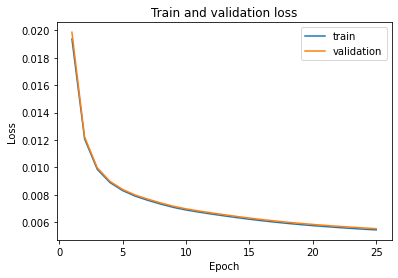

In [ ]:
# batch = 200
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    ### changed below
    "batch_size": 200,
    ### changed above
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

# PART B - Conditional GAN

In this second half of the assignment we will construct a conditional generative adversarial network for our image colourization task.

## Part 1. Conditional GAN

To start we will be modifying the previous sample code to construct and train a conditional GAN. We will exploring the different architectures to identify and select our best image colourization model.


[good articles on this in chinese](https://https://baidudanao.blog.csdn.net/article/details/109792341?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EOPENSEARCH%7Edefault-2-109792341-blog-78660741.pc_relevant_landingrelevant&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EOPENSEARCH%7Edefault-2-109792341-blog-78660741.pc_relevant_landingrelevant&utm_relevant_index=3)

### Part (a)
Modify the provided training code to implement a generator. Then test to verify it works on the desired input

In [ ]:
class Generator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours = 3, num_in_channels = 1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1
           
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.finalconv = nn.Conv2d(num_filters+1, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
                                          # input    # output
        out1 = self.downconv1(x)          # 1 ,32,32 # 32,16,16
        out2 = self.downconv2(out1)       # 32,16,16 # 64, 8, 8
        out3 = self.rfconv(out2)          # 64, 8, 8 # 64, 8, 8
        out4 = self.upconv1(out3)         # 64, 8, 8 # 32,16,16 
        out4 = torch.cat((out4, out1),1)  # skip connection # 32 + 32 = 64
        out5 = self.upconv2(out4)         # 32,16,16 # 1, 32,32 # 64 -> 32
        out5 = torch.cat((out5, x   ),1)  # skip connection # 32 + 1  = 33
        out6 = self.finalconv(out5)       # 1, 32,32 # 3, 32,32 # 33 -> 3
        
        return out6

In [ ]:
# get torch data
(x_train, y_train), (x_test, y_test) = load_cifar10()
    
train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
test_rgb , test_grey  = process(x_test,  y_test,  downsize_input=args.downsize_input)

valid_rgb  = train_rgb[4000:,:,:,:]
train_rgb  = train_rgb[:4000,:,:,:]
valid_grey = train_grey[4000:,:,:,:]
train_grey = train_grey[:4000,:,:,:]

xs = train_grey[:5,:,:,:]
ys = train_rgb[:5,:,:,:]
test_images, test_labels = get_torch_vars(xs, ys, args.gpu)

File path: data/cifar-10-batches-py.tar.gz


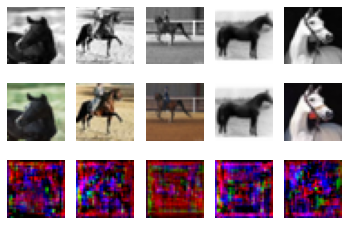

In [ ]:
# test generator architecture
generator = Generator(kernel = 3, num_filters = 32).cuda()
outputs = generator(test_images)

visual(test_images, test_labels, outputs, args.gpu, 1)
# result: can process img with the initial weights

### Part (b)
Modify the provided training code to implement a discriminator. Then test to verify it works on the desired input.

In [ ]:
# discriminator code

class Discriminator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=4):
        super().__init__()
        
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv4 = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*8, kernel_size=kernel, padding=padding, stride = 2),
            nn.BatchNorm2d(num_filters*8),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.fullyconnect1 = nn.Linear(256, 16)
        self.fullyconnect2 = nn.Linear(16, 1)
    
    def forward(self, x, img_greyscale):

        # x: B, 3, 32, 32
        # g: B, 1, 32, 32
        
        x = torch.cat([x, img_greyscale], 1) # input    # output
        out1 = self.downconv1(x)             # 4 ,32,32 # 32,16,16
        out2 = self.downconv2(out1)          # 32,16,16 # 64, 8, 8
        out3 = self.downconv3(out2)          # 64, 8, 8 # 128, 4, 4
        out4 = self.downconv4(out3)          # 128,4, 4 # 256, 1, 1
        # classifier
        out5 = out4.view(out4.size(0), 256)
        out6 = self.fullyconnect1(out5)
        out7 = self.fullyconnect2(out6)

        return out7.squeeze()

In [ ]:
# test discriminator architecture
discriminator = Discriminator(kernel = 3, num_filters = 32).cuda()
outputs2 = discriminator(test_labels, test_images)
print(outputs2)
# result: can process img with the the probability between
# they are not in (0,1) with sigmoid because I would use
# BCEWithLogitsLoss() instead of BCELoss() later

tensor([-0.5794,  0.1369,  0.0516,  0.1433,  0.0247], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


### Part (c)
Modify the provided training code to implement a conditional GAN.

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, img_grey, img_real):
  # 1 -> real, 0 -> generated
  d_optimizer.zero_grad()

  # train with real images
  real_validity = discriminator(img_real, img_grey)
  real_loss = criterion(real_validity,  Variable(torch.ones(batch_size)).cuda())
    
  # train with fake images
  fake_images = generator(img_grey)
  fake_validity = discriminator(fake_images, img_grey)
  fake_loss = criterion(fake_validity,  Variable(torch.zeros(batch_size)).cuda())
    
  d_loss = real_loss + fake_loss
  d_loss.backward()
  d_optimizer.step()
  # return d_loss.data[0]
  return d_loss.item()

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, img_grey):
  # 1 -> real, 0 -> generated
  g_optimizer.zero_grad()

  # genearte imgs and feed to discriminator
  fake_images = generator(img_grey)
  validity = discriminator(fake_images, img_grey)
  g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
  
  g_loss.backward()
  g_optimizer.step()
  # return g_loss.data[0]
  return g_loss.item()

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train_gan(args, generator=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if generator is None:
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        Net1 = globals()['Generator']
        generator     = Net1(args.kernel, args.num_filters)
        Net2 = globals()['Discriminator']
        discriminator = Net2(args.kernel, args.num_filters)
    else: 
        generator     = generator
        Net2 = globals()['Discriminator']
        discriminator = Net2(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion =  nn.BCEWithLogitsLoss()                                                   
    g_optimizer = torch.optim.Adam(generator.parameters(),     lr = args.g_lr)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = args.d_lr)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    print("Spliting data...")
    # split training set into train/validation set
    valid_rgb  = train_rgb[4000:,:,:,:]
    train_rgb  = train_rgb[:4000,:,:,:]
    valid_grey = train_grey[4000:,:,:,:]
    train_grey = train_grey[:4000,:,:,:]

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        generator.cuda()
        discriminator.cuda()
    start = time.time()

    d_losses = []
    g_losses = []
    for epoch in range(args.epochs):
      # Train the Model
      generator.train()
      discriminator.train()
      losses = []
  
      for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)

        #--->ADDED 5
        img_grey = images
        img_real = labels
        batch_size = args.batch_size
            
        # discriminator training
        d_loss = discriminator_train_step(batch_size, discriminator, generator, 
                                              d_optimizer, criterion, img_grey, img_real)
        # generator training
        g_loss = generator_train_step(batch_size, discriminator, generator, 
                                          g_optimizer, criterion, img_grey)
      d_losses.append(d_loss)
      g_losses.append(g_loss)
        # print and visualize
      if (epoch+1)%10 == 0:
        print("epoch: %d, gloss: %.5f, dloss: %.5f." %(epoch+1, g_loss, d_loss))
    generator.eval()
    discriminator.eval()
    # visualize training
    images, labels = get_torch_vars(train_grey[:5,:,:,:], train_rgb[:5,:,:,:], args.gpu)
    outputs = generator(images)
    visual(images, labels, outputs, args.gpu, 1) 
    # plotting
    plotting2(d_losses, g_losses)

    return generator

In [ ]:
# visualize training curve
def plotting2(d_losses, g_losses):
  n = len(d_losses)
  plt.title("generator and discriminator loss")
  plt.plot(range(1, n+1), d_losses, label = "discriminator")
  plt.plot(range(1, n+1), g_losses, label = "generator")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc = "best")
  plt.show()

### Part (d)
Train a conditional GAN for image colourization.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Spliting data...
Beginning training ...
epoch: 10, gloss: 9.15484, dloss: 0.00112.
epoch: 20, gloss: 8.49389, dloss: 0.00054.
epoch: 30, gloss: 5.67217, dloss: 0.21915.
epoch: 40, gloss: 6.61901, dloss: 0.06765.
epoch: 50, gloss: 6.55514, dloss: 0.01957.
epoch: 60, gloss: 3.86230, dloss: 0.19026.
epoch: 70, gloss: 4.90673, dloss: 0.65810.
epoch: 80, gloss: 6.72292, dloss: 1.11995.
epoch: 90, gloss: 10.21357, dloss: 0.59738.
epoch: 100, gloss: 9.97938, dloss: 0.00245.
epoch: 110, gloss: 4.92521, dloss: 0.02669.
epoch: 120, gloss: 7.27500, dloss: 0.01608.
epoch: 130, gloss: 6.60085, dloss: 0.05109.
epoch: 140, gloss: 5.03961, dloss: 0.02921.
epoch: 150, gloss: 19.53030, dloss: 0.17327.
epoch: 160, gloss: 5.42536, dloss: 0.03723.
epoch: 170, gloss: 5.30569, dloss: 0.16633.
epoch: 180, gloss: 11.20825, dloss: 0.00167.
epoch: 190, gloss: 9.47948, dloss: 0.04736.
epoch: 200, gloss: 7.72004, dloss: 0.00293.


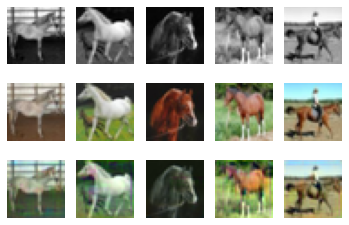

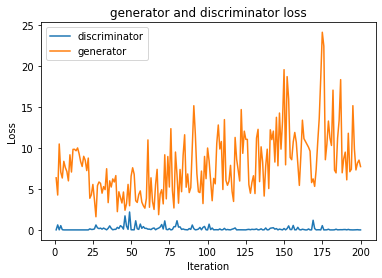

In [ ]:
# try1: both G and D learning rate = 0.001
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    'g_lr': 0.001,
    'd_lr': 0.001,
    "batch_size": 50,
    "epochs": 200,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn1 = train_gan(args)

#batch size of 50 with 100 epochs seamed to work

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Spliting data...
Beginning training ...
epoch: 10, gloss: 0.70432, dloss: 1.46615.
epoch: 20, gloss: 0.72100, dloss: 1.38336.
epoch: 30, gloss: 0.69369, dloss: 1.39862.
epoch: 40, gloss: 0.68671, dloss: 1.39856.
epoch: 50, gloss: 0.69331, dloss: 1.38776.
epoch: 60, gloss: 0.69434, dloss: 1.38433.
epoch: 70, gloss: 0.69686, dloss: 1.37772.
epoch: 80, gloss: 0.70175, dloss: 1.36338.
epoch: 90, gloss: 0.70595, dloss: 1.35426.
epoch: 100, gloss: 0.71909, dloss: 1.34011.
epoch: 110, gloss: 0.74363, dloss: 1.30579.
epoch: 120, gloss: 0.76819, dloss: 1.26477.
epoch: 130, gloss: 0.77263, dloss: 1.25506.
epoch: 140, gloss: 0.82000, dloss: 1.19507.
epoch: 150, gloss: 0.90521, dloss: 1.09291.
epoch: 160, gloss: 0.89691, dloss: 1.07018.
epoch: 170, gloss: 0.93906, dloss: 0.99413.
epoch: 180, gloss: 0.97624, dloss: 0.96694.
epoch: 190, gloss: 1.17115, dloss: 0.83107.
epoch: 200, gloss: 1.24963, dloss: 0.77535.


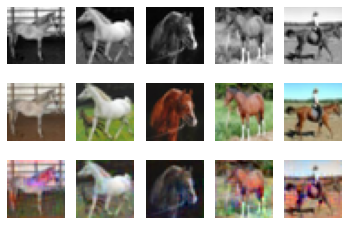

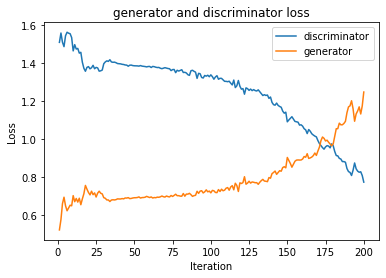

In [ ]:
# try2: G learning rate = 0.001, D learning rate = 0.00001
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.0001,
    'g_lr': 0.001,
    'd_lr': 0.00001,
    "batch_size": 50,
    "epochs": 200,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn2 = train_gan(args)

#batch size of 50 with 100 epochs seamed to work

In [ ]:
# I think cnn1 is better than cnn2, so I save the cnn1 model
torch.save(cnn1.state_dict(), '1029_cGAN')

File path: data/cifar-10-batches-py.tar.gz


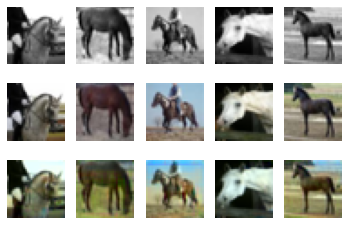

In [ ]:
# parameter reloading
cnn_load = Generator(args.kernel, args.num_filters)
state = torch.load('/content/1029_cGAN')
cnn_load.load_state_dict(state)

# visualize 5 imgs in the test set
if args.gpu:
  cnn_load.cuda()

cnn_load.eval()
npr.seed(args.seed)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

(x_train, y_train), (x_test, y_test) = load_cifar10()
test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)
images, labels = get_torch_vars(test_grey[-5:,:,:,:], test_rgb[-5:,:,:,:], args.gpu)
outputs = cnn_load(images)
visual(images, labels, outputs, args.gpu, 1) 

### Part (e)
How does the performance of the cGAN compare with the autoencoder models that you tested in the first half of this assignment?

The colorized images from the previous are blurry and more like to be brown (even the grass is brown sometimes). The performance of this cGAN is better (especially in the training set) since it generates images that are more clear and closer to the original images in color.

### Part (f)

A colour space is a choice of mapping of colours into three-dimensional coordinates. Some colours could be close together in one colour space, but further apart in others. The RGB colour space is probably the most familiar to you, the model used in in our regression colourization example computes squared error in RGB colour space. But, most state of the art colourization models
do not use RGB colour space. How could using the RGB colour space be problematic? Your answer should relate how human perception of colour is different than the squared distance. You may use the Wikipedia article on colour space to help you answer the question.

From my perspective, using RGB is the simplest way not only for the computer to process but also algorithm to understand. However, using RGB, which describes what kind of light needs to be emitted to produce a given color, may not be straight-forward for human being. 

RGB allows representing only 40% of the colors that the human eye can perceive. CIE suggests color spaces should be what humanality can actually perceive. CIE XYZ provides an extension of RGB and considers luminance. Moreover, Hue and Saturation are also important for human perception. All of those are beyond simple MSE. If the creterion is only MSE, then human only compare images by decomposing color to green/red/blue and make each corresponding layer fit. Since Deep Learning is from humanality and also it is the people perception (also the loss functions) that decides whether a algorithm is good, it would be better to not only consider RGB, but other possibilities.

## Part 2. Exploration

At this point we have trained a few different generative models for our image colourization task with varying results. What makes this work exciting is that there many other approaches we could take. In this part of the assignment you will be exploring at least one of several approaches towards improving our performance on the image colourization task. Some well known approaches you can consider include:

- lab colour space representation instead of RBG which simplifies the problem and requires you to predict two output channels instead of three
- k-means to represent RBG colourspace by 'k' distinct colours, this effectively changes the problem from regression to classification.

Other interesting approaches include:
- combining L1 loss along with the discriminator-based loss
- starting with a pretrained generator (i.e. Resnet)
- patch discriminator trained on local regions

A great example of some of these different approaches can be found in a <a href="https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8">blog post by Moein Shariatnia</a>.

Note you are only required to pick one of the suggested modifications.

In [ ]:
# I am here tring <lab color space> & <L1 loss with cGAN loss>.
print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Extracting file.
Transforming data...


In [ ]:
from skimage.color import rgb2lab, lab2rgb

# from rgb to lab
def rgbtolab(x):
  img = np.transpose(x, (0,2,3,1))
  img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
  L  = np.transpose(img_lab[:,:,:,[0]], (0,3,1,2))
  ab = np.transpose(img_lab[:,:,:,[1,2]] , (0,3,1,2))
  return L, ab

# from rgb dataset to lab dataset
def Tolab():
  (x_train, y_train), (x_test, y_test) = load_cifar10()

  train_rgb, train_gray = process(x_train, y_train)
  test_rgb, test_gray = process(x_test, y_test)

  gray_train, ab_train = rgbtolab(train_rgb)
  gray_test,  ab_test  = rgbtolab(test_rgb)
  return gray_train, ab_train, gray_test, ab_test

gray_train, ab_train, gray_test, ab_test = Tolab()

File path: data/cifar-10-batches-py.tar.gz


In [ ]:
def discriminator_train_step_lab(batch_size, discriminator, generator, d_optimizer, criterion, img_grey, img_real):
  # 1 -> real, 0 -> generated
  d_optimizer.zero_grad()

  # train with real images
  real_validity = discriminator(img_real, img_grey)
  real_loss = criterion(real_validity,  Variable(torch.ones(batch_size)).cuda())
    
  # train with fake images
  fake_images = generator(img_grey)
  fake_validity = discriminator(fake_images, img_grey)
  fake_loss = criterion(fake_validity,  Variable(torch.zeros(batch_size)).cuda())
    
  d_loss = real_loss + fake_loss
  d_loss.backward()
  d_optimizer.step()
  # return d_loss.data[0]
  return d_loss.item()

def generator_train_step_lab(batch_size, discriminator, generator, g_optimizer, criterion, img_grey, img_real, lambda_L1):
  # 1 -> real, 0 -> generated
  L1criterion = nn.L1Loss()
  g_optimizer.zero_grad()

  fake_images = generator(img_grey)
  validity = discriminator(fake_images, img_grey)
  g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
  ### L1 loss
  L1_loss = L1criterion(fake_images, img_real) * lambda_L1
  
  g_loss_sum = g_loss + L1_loss
  g_loss_sum.backward()
  g_optimizer.step()
  # return g_loss.data[0]
  return g_loss.item()

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

In [ ]:
def train_lab(args, generator=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if generator is None:
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        Net1 = globals()['Generator']
        generator     = Net1(args.kernel, args.num_filters, num_colours = 2)
        Net2 = globals()['Discriminator']
        discriminator = Net2(args.kernel, args.num_filters, num_in_channels = 3)
    else: 
        generator     = generator
        Net2 = globals()['Discriminator']
        discriminator = Net2(args.kernel, args.num_filters, num_in_channels = 3)

    # LOSS FUNCTION
    criterion =  nn.BCELoss()                                                   
    g_optimizer = torch.optim.Adam(generator.parameters(),     lr=1e-3)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

    # DATA
    print("Loading data...")
    gray_train, ab_train, gray_test, ab_test = Tolab()

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        generator.cuda()
        discriminator.cuda()
    start = time.time()

    d_losses = []
    g_losses = []
    lambda_L1 = 10
    for epoch in range(args.epochs):
      # Train the Model
      generator.train()
      discriminator.train()
      losses = []
  
      for i, (xs, ys) in enumerate(get_batch(gray_train, ab_train, args.batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)

        #--->ADDED 5
        img_grey = images
        img_real = labels
        batch_size = args.batch_size
            
        # discriminator training
        d_loss = discriminator_train_step_lab(batch_size, discriminator, generator, 
                                          d_optimizer, criterion, img_grey, img_real)
        # generator training
        g_loss = generator_train_step_lab(batch_size, discriminator, generator, 
                                      g_optimizer, criterion, img_grey, img_real, lambda_L1)
      d_losses.append(d_loss)
      g_losses.append(g_loss)
        # print and visualize
      if (epoch+1)%10 == 0:
        print("epoch: %d, gloss: %.5f, dloss: %.5f." %(epoch+1, g_loss, d_loss))
    generator.eval()
    discriminator.eval()
    # visualization and plotting
    images, labels = get_torch_vars(gray_train[:5,:,:,:], ab_train[:5,:,:,:], args.gpu)
    outputs = generator(images)
    visual_lab(images, labels, outputs, args.gpu, 1)
    plotting2(d_losses, g_losses)

    return generator

In [ ]:
# visualize 5 train/test images
def visual_lab(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1])
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  img_real = lab2rgb(np.concatenate((img_grey, img_real),3))
  img_fake = lab2rgb(np.concatenate((img_grey, img_fake),3))

  for i in range(5): # clip to [0,1]
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey.squeeze()[i], cmap='gray')#, vmin = 0, vmax = 1)
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])#, vmin = 0, vmax = 1)
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])#, vmin = 0, vmax = 1)
      ax.axis("off")
  plt.show()

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Beginning training ...
epoch: 10, gloss: 8.46970, dloss: 0.14359.
epoch: 20, gloss: 5.43352, dloss: 0.08540.
epoch: 30, gloss: 8.72197, dloss: 0.04873.
epoch: 40, gloss: 9.24148, dloss: 0.19647.
epoch: 50, gloss: 5.03023, dloss: 0.04999.
epoch: 60, gloss: 8.79382, dloss: 0.01523.
epoch: 70, gloss: 8.75853, dloss: 0.05491.
epoch: 80, gloss: 5.63414, dloss: 0.01984.
epoch: 90, gloss: 9.14992, dloss: 0.00182.
epoch: 100, gloss: 8.27042, dloss: 0.00194.


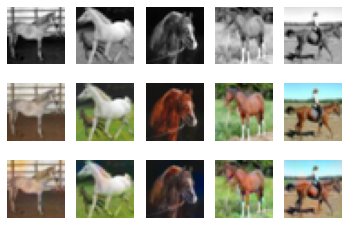

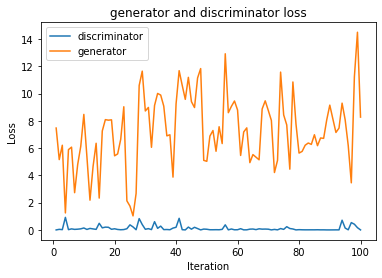

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn_lab = train_lab(args)

#batch size of 50 with 100 epochs seamed to work

In [ ]:
# save the model
torch.save(cnn_lab.state_dict(), '1030_lab')

File path: data/cifar-10-batches-py.tar.gz


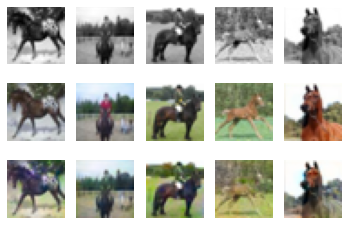

In [ ]:
# parameter reloading
lab_load = Generator(args.kernel, args.num_filters, num_colours = 2)
state = torch.load('/content/1030_lab')
lab_load.load_state_dict(state)

# visualize 5 imgs in test set
if args.gpu:
  lab_load.cuda()
lab_load.eval()
npr.seed(args.seed)

gray_train, ab_train, gray_test, ab_test = Tolab()
images, labels = get_torch_vars(gray_test[-5:,:,:,:], ab_test[-5:,:,:,:], args.gpu)
outputs = lab_load(images)
visual_lab(images, labels, outputs, args.gpu, 1)

## Part 3. New Data
Retrieve sample pictures from online and demonstrate how well your best model performs. Provide all your code.

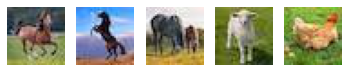

In [ ]:
# I want to know if the model has generalization ability on other animals
# even though it was trained all by horses.

# after resizing and uploading pictures:
# 1st: normal
# 2nd: with blue backgroud
# 3rd: 2 horses
# 4th: lamb
# 5th: chicken
pic1 = plt.imread('/content/download1.jpeg')
pic2 = plt.imread('/content/download2.jpeg')
pic3 = plt.imread('/content/download3.jpeg')
pic4 = plt.imread('/content/download4.jpeg')
pic5 = plt.imread('/content/download5.jpeg')
pics = np.array([pic1, pic2, pic3, pic4, pic5])

for i in range(5):
  ax = plt.subplot(1, 5, i+1)
  ax.imshow(pics[i])
  ax.axis("off")
plt.show()

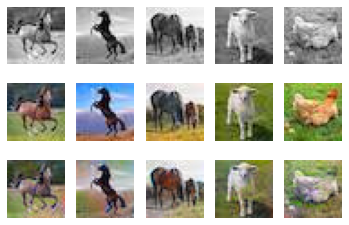

In [ ]:
def Onlinetolab(x):
  img_lab = rgb2lab(x).astype("float32") # Converting RGB to L*a*b
  L  = np.transpose(img_lab[:,:,:,[0]], (0,3,1,2))
  ab = np.transpose(img_lab[:,:,:,[1,2]] , (0,3,1,2))
  return L, ab

gray_img, ab_img = Onlinetolab(pics)

gray_img, ab_img = get_torch_vars(gray_img, ab_img, args.gpu)
pred_img = cnn_lab(gray_img)

gray_img = gray_img.cpu().detach().numpy()
ab_img   = ab_img.cpu().detach().numpy()
pred_img = pred_img.cpu().detach().numpy()

gray_img = np.transpose(gray_img[:5, :, :, :], [0, 2, 3, 1])
ab_img   = np.transpose(ab_img[:5, :, :, :], [0, 2, 3, 1])
pred_img = np.transpose(pred_img[:5, :, :, :], [0, 2, 3, 1])

real_img = lab2rgb(np.concatenate((gray_img, ab_img),3))
fake_img = lab2rgb(np.concatenate((gray_img, pred_img),3))

for i in range(5):
  ax = plt.subplot(3, 5, i + 1)
  ax.imshow(gray_img.squeeze()[i], cmap='gray')#, vmin = 0, vmax = 1)
  ax.axis("off")
  ax = plt.subplot(3, 5, i + 1 + 5)
  ax.imshow(real_img[i])#, vmin = 0, vmax = 1)
  ax.axis("off")
  ax = plt.subplot(3, 5, i + 1 + 10)
  ax.imshow(fake_img[i])#, vmin = 0, vmax = 1)
  ax.axis("off")
plt.show()

The 1st and 4th ones are well predicted. However, in 2nd one, the sky is not the blue; in 3rd one, the color of horses are more brown; in the fifth one, the color of chicken is totally turned into full white. Since the model was trained with horses, most prediction are still based on the features of horses. For example, most training sample are white/brown horses in the green background (most are grass). To make it well generalizing on more images, training sample could be having more categories.

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_3_Generating_Data_1104.ipynb

[NbConvertApp] Converting notebook LAB_3_Generating_Data_1104.ipynb to html
[NbConvertApp] Writing 3245469 bytes to LAB_3_Generating_Data_1104.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus